### Imports

In [64]:
import math
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D


### Distância de Minkowski

In [65]:
def calculateDist(p1, p2, n):
    return ((abs(p1[0] - p2[0])**n) + (abs(p1[1] - p2[1])**n)) ** (1/n)

* __Distância Manhattan__ __->__  n = 1

* __Distância Euclidiana__ __->__  n = 2


### Função para vizualização

Para pontos em duas dimensões

In [66]:
def plotClusters2D(clusters,n):
    
    plt.figure(figsize=(8, 8))
    colors = plt.get_cmap('Set1', len(clusters))  
    
    for i, cluster in enumerate(clusters):
        cluster_points = np.array(cluster)
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors(i), label=f'Cluster {i + 1}')
        
        #Centro do cluster
        center = np.array(cluster[0])
        plt.scatter(center[0], center[1], color='black', marker='x')
        
        #Raio
        max_dist = max([calculateDist(center, p,n) for p in cluster])
        circle = plt.Circle(center, max_dist, color=colors(i), fill=False, linestyle='--')
        plt.gca().add_patch(circle)
        plt.text(center[0], center[1] + max_dist + 0.3, f'Raio: {max_dist:.2f}', color=colors(i), ha='center')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Clusters')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()


Para pontos em três dimensões

In [67]:
def plotClusters3D(clusters, n):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    colors = plt.get_cmap('Set1', len(clusters))
    
    for i, cluster in enumerate(clusters):
        cluster_points = np.array(cluster)
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], color=colors(i), label=f'Cluster {i + 1}')
        
        # Centro do cluster
        center = np.mean(cluster_points, axis=0)
        ax.scatter(center[0], center[1], center[2], color='black', marker='x')
        
        # Raio
        max_dist = max([calculateDist(center, p, n) for p in cluster])
        
        #Nesse caso temos uma esfera e não circulo
        u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
        x = max_dist * np.cos(u) * np.sin(v) + center[0]
        y = max_dist * np.sin(u) * np.sin(v) + center[1]
        z = max_dist * np.cos(v) + center[2]
        
        ax.plot_surface(x, y, z, color=colors(i), alpha=0.3, edgecolor='none')
        ax.text(center[0], center[1], center[2] + max_dist + 0.3, f'Raio: {max_dist:.2f}', color=colors(i), ha='center')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Clusters')
    ax.legend()
    plt.show()

Para várias dimensões a vizualização em gráficos fica inviável

In [68]:
def printClusters(clusters,n):
    
    print(f"Clusters encontrados: {len(clusters)}")
    for i, cluster in enumerate(clusters):
        print(f"Cluster {i + 1}:")
        print(f"Pontos: {cluster}")
        max_dist = max([calculateDist(cluster[0], p,2) for p in cluster])
        print(f"Raio do Cluster: {max_dist}")

### Primeira versão do algoritmo 2-aproximado

Nessa versão  o intervalo para o raio ótimo é refinado até uma largura definida. Primeiramente vamos definir funções auxiliares para conseguir fazer o algoritmo:

In [69]:
#Função responsável por determinar se é possível dado um conjunto de pontos achar k clusters de raio maximo 2 rmax

def findSolution(pontos, rmax, k,n):
    success = False
    solution = []
    clusters = []
    pts = pontos[:]
    
    while pts:
        current_p = pts.pop(0)
        solution.append(current_p)
        cluster = [current_p]
        
        pts_to_remove = []
        for p in pts:
            if calculateDist(current_p, p, n) < 2 * rmax:
                cluster.append(p)
                pts_to_remove.append(p)
        
        for p in pts_to_remove:
            pts.remove(p)
        
        clusters.append(cluster)
    
    if len(solution) <= k:
        success = True
    
    return success, clusters


In [70]:
#Função que acha a maior distância entre dois pontos

def maxDist(pontos,n):
    currentMax = 0
    for i, p1 in enumerate(pontos):
        for j, p2 in enumerate(pontos):
            if i != j:
                currentDist = calculateDist(p1,p2, n) 
                if currentDist > currentMax:
                    currentMax = currentDist
    return currentMax

Agora podemos ir para a implementação do algoritmo em si:

In [71]:
def k_clustering(pontos,porcentagem_largura,k_clusters,n_distancia):
    limite_superior = maxDist(pontos,n_distancia)
    limite_inferior = 0
    
    largura_total = limite_superior - limite_inferior 
    
    raio = limite_superior/2
    
    while (limite_superior-limite_inferior) >= (porcentagem_largura*largura_total):
        sucess, clusters = findSolution(pontos, raio, k_clusters,n_distancia)
        if sucess:
            limite_superior = raio
            raio = limite_superior/2
        else:
            limite_inferior = raio
            raio = raio + raio/2
            
    
    return clusters 

In [72]:
pontos = [[6, 3], [-10, -4], [-9, 0], [5, 5], [8, 3], [7, 2], [4, 4], [7, 6], [-8, -2], [2, 5]]

In [73]:
clusters = k_clustering(pontos,0.25,3,2)

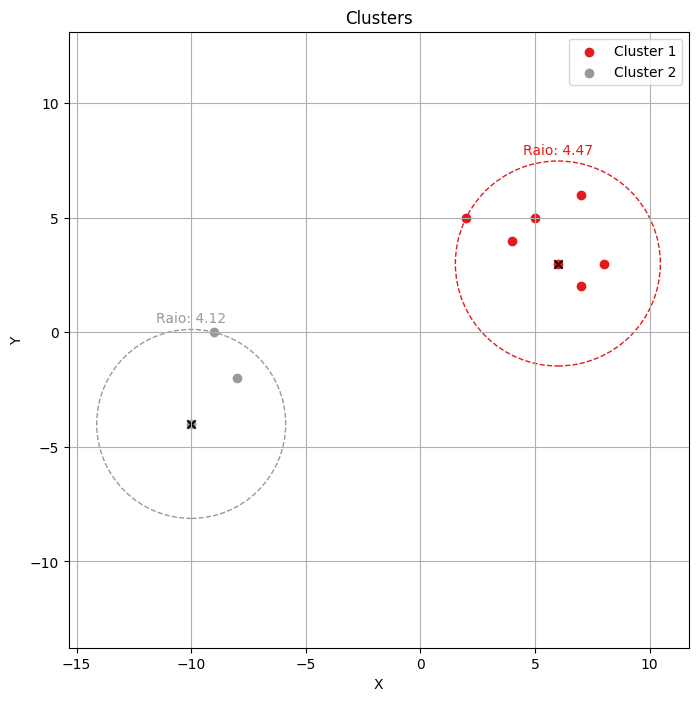

In [74]:
plotClusters2D(clusters,2)

### Segunda versão do algoritmo 2-aproximado

Nessa os centros são escolhidos para maximizar a distância entre os centros previamente escolhidos

In [75]:
#Calcula o ponto com a máxima distância mínima aos pontos em centers
def mostDistant(pontos, centers, n):
    maxDist = 0
    for p in pontos:
        if p not in centers:
            minDist = np.inf
            for c in centers:
                dist = calculateDist(p, c, n)
                if dist < minDist:
                    minDist = dist
            if minDist > maxDist:
                maxDist = minDist
                p_choice = p
    return p_choice

#Determina os centros dos clusters
def getCenters(pontos,k_clusters,n):
    if k_clusters >= len(pontos):
        return pontos
    
    centers = [pontos[0]]
    while (len(centers) < k_clusters):
        s = mostDistant(pontos, centers, n)
        centers.append(s)
    return centers

#Determina o centro mais próximo do ponto p
def find_closest_center(centers, p, n):
    minDist = np.inf
    for c in centers:
        dist = calculateDist(p, c, n)
        if dist < minDist:
            minDist = dist
            closest_center = c
    return closest_center

#Determina os clusters por meio da maximização dos centros já escolhidos
def makeClusters(pontos, k_clusters, n):
    centers = getCenters(pontos, k_clusters, n)
    clusters = [[c] for c in centers] # inicializa os clusters apenas com o centro
    for p in pontos:
        closest_center = find_closest_center(centers, p, n)
        clusters[centers.index(closest_center)].append(p)
    return clusters


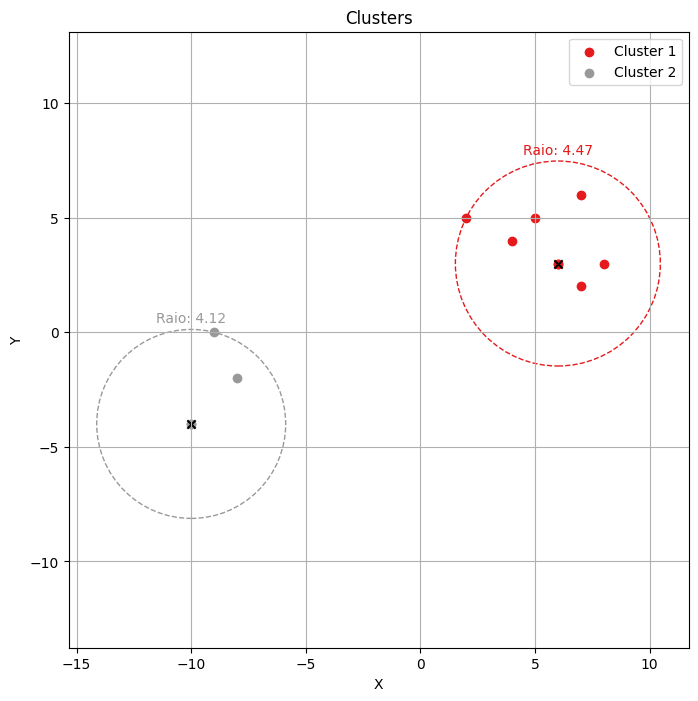

In [76]:
clusters = makeClusters(pontos,2,2) # formar 2 clusters usando distância euclidiana
plotClusters2D(clusters,2)

### Testes

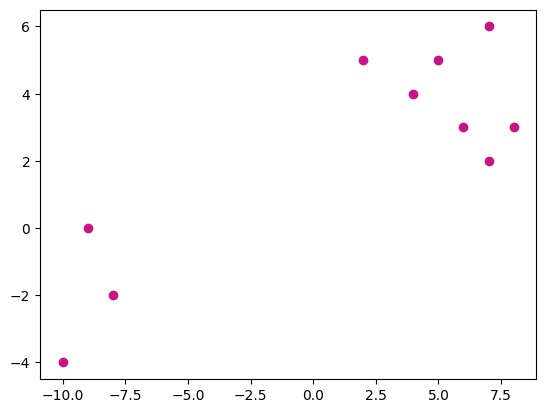

In [77]:
ptx = [p[0] for p in pontos]
pty = [p[1] for p in pontos]
plt.plot(ptx, pty, marker='o', linestyle='None', color='mediumvioletred')